# Week 7 Lab 3.3
## Airport Delay dataset with pipeline from clustering/unsupervised to classification/supervised

In [210]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot') 

## 1. Format the Data

In [211]:
ap = pd.read_csv('../../assets/datasets/airport2.csv')
ap.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,242,235,71,46
1,ABQ,2005,221,190,61,33
2,ABQ,2006,392,329,71,124
3,ABQ,2007,366,304,107,45
4,ABQ,2008,333,300,79,42


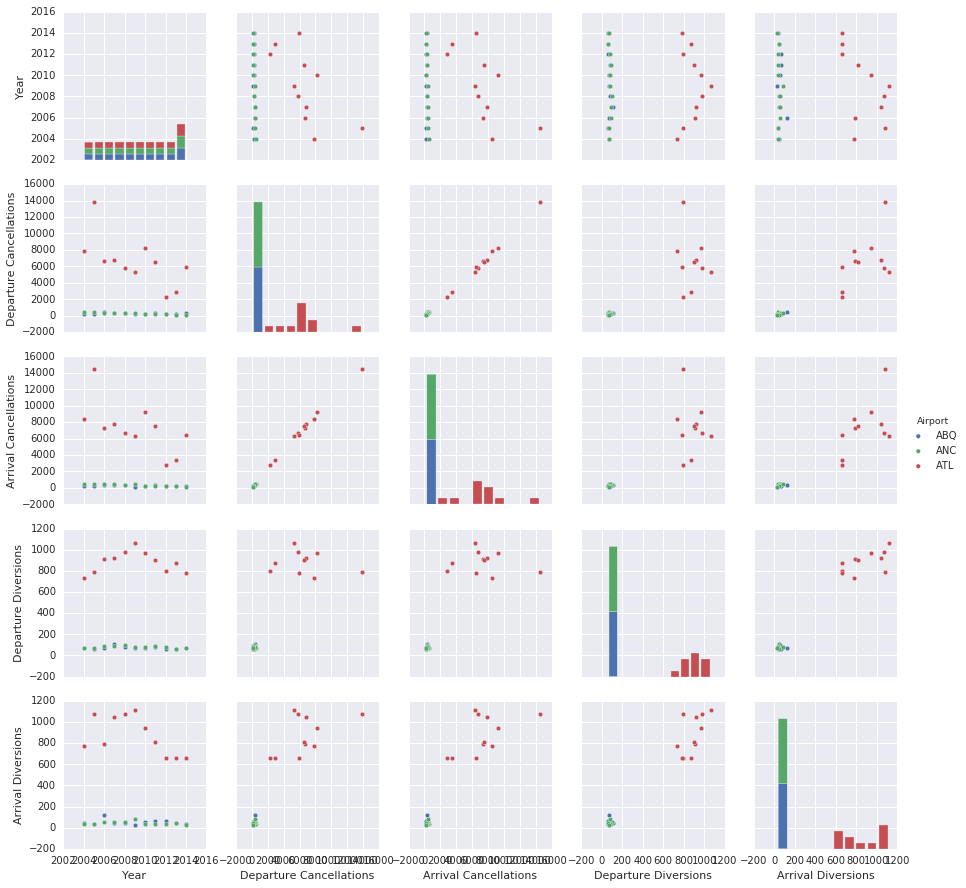

In [212]:
#plot before change Airport to numeric
# Do you see any patterns in relationships of the scatter plot matrix
sns.set()
sns.pairplot(ap, hue="Airport")

Convert the class labels, in this case the airports, to numeric. *Remember*, we've truncated the airport dataset for simplicty to make this part easy! 

In [213]:
def air_to_numeric(x):
    if x=='ABQ':
        return 1
    if x=='ANC':
        return 2
    if x=='ATL':
        return 3

In [214]:
ap['Airport'] = ap['Airport'].apply(air_to_numeric)

## 2. Plot the data
Consider outsourcing your EDA to tableau

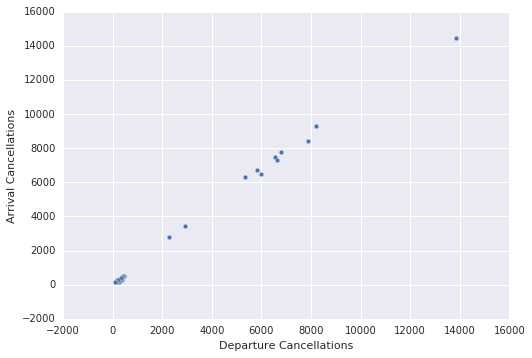

In [215]:
ap.plot(kind='scatter',x='Departure Cancellations',y='Arrival Cancellations')

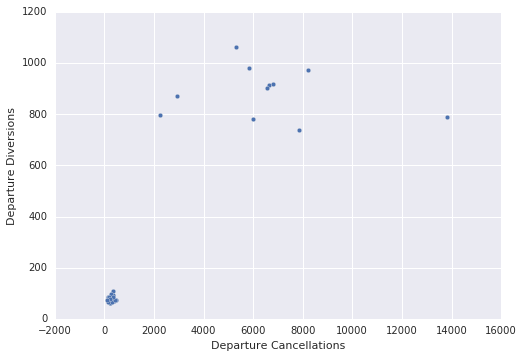

In [216]:
ap.plot(kind='scatter',x='Departure Cancellations',y='Departure Diversions')

**Question**: Based on the graphs, how many clusters do you estimate that we have?

# A SECTION
## 3.  KMEANS =Perform a K-Means Clustering 

**Suggested additions:** 
- loop through different k values,  ways of initializing k-means clustering, and distance measures
- Add at least one way to scale the data 
- Graph and compare the groupings of labels given different paramters
- Compare and graph silhoutte scores and enertia (Sum of distances of samples to their closest cluster center) for each set of parameters used
- Visualize and describe the values with cluster labels -- consider outsourcing to tableau. Apply a story to different clusters

Remember: The Silhouette Coefficient for a sample is (sample_dist_nearest_cluster - intra_c_dist) / max(intra_c_dist, sample_dict_nearest_cluster). 
- b is the distance between a sample and the nearest cluster that the sample is not a part of.
- a is mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample

 Silhouette Coefficent is only defined if number of labels is 2 <= n_labels <= n_samples - 1.


#### 3.1 Split the dataset into the attribute data and class labels

In [217]:
x = ap.ix[:,1:5]
y = ap.ix[:,0]

In [251]:
X = x.as_matrix(columns=None)
print X

[[ 2004   242   235    71]
 [ 2005   221   190    61]
 [ 2006   392   329    71]
 [ 2007   366   304   107]
 [ 2008   333   300    79]
 [ 2009   192   162    74]
 [ 2010   222   177    71]
 [ 2011   345   294    77]
 [ 2012   237   181    65]
 [ 2013   232   212    62]
 [ 2014   315   274    66]
 [ 2004   473   532    73]
 [ 2005   424   484    74]
 [ 2006   367   436    88]
 [ 2007   359   423    93]
 [ 2008   268   355    97]
 [ 2009   354   421    84]
 [ 2010   149   204    84]
 [ 2011   191   265    87]
 [ 2012   216   284    78]
 [ 2013   141   184    65]
 [ 2014   111   162    74]
 [ 2004  7870  8433   737]
 [ 2005 13837 14480   790]
 [ 2006  6624  7301   913]
 [ 2007  6796  7790   920]
 [ 2008  5830  6705   982]
 [ 2009  5324  6303  1064]
 [ 2010  8198  9279   971]
 [ 2011  6555  7484   903]
 [ 2012  2259  2782   798]
 [ 2013  2916  3450   870]
 [ 2014  5977  6483   781]]


#### 3.2 Conduct the k-means clustering

In [219]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### 3.3 Compute the labels and centroids

In [220]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [221]:
print(labels)
print(centroids)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 0 0 1]
[[  2009.29166667    471.875         526.66666667    140.375     ]
 [  2008.625        6646.75         7472.25          908.875     ]
 [  2005.          13837.          14480.            790.        ]]


#### 3.4 Format the resulting predicted "y" variables and check the accuracy score, classification report, and confusion matrix

In [222]:
metrics.accuracy_score(y, labels)

0.0

In [223]:
print(metrics.classification_report(y, labels))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00        11
          2       0.00      0.00      0.00        11
          3       0.00      0.00      0.00        11

avg / total       0.00      0.00      0.00        33



In [224]:
print(metrics.confusion_matrix(y, labels))

[[ 0  0  0  0]
 [11  0  0  0]
 [11  0  0  0]
 [ 2  8  1  0]]


In [225]:
metrics.silhouette_score(x, labels, metric='euclidean')

0.87898661007879986

**Question**: What are we understand from this these performance metrics? 

# KMEANS to Classification
## Kmeans labels to Extra Trees Classifier
### Builds models with kmeans labels as targets

Suggested addition: 
- Build this section with test/train split and/or cross validation
- Output and Compare classification results from the "best" and "worse" labels

In [226]:
trees = ExtraTreesClassifier()
trees.fit(X, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [227]:
importances = trees.feature_importances_
print(importances)
print(ap.columns[2:-1])

[ 0.04222258  0.38101877  0.25037202  0.32638663]
Index([u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions'],
      dtype='object')


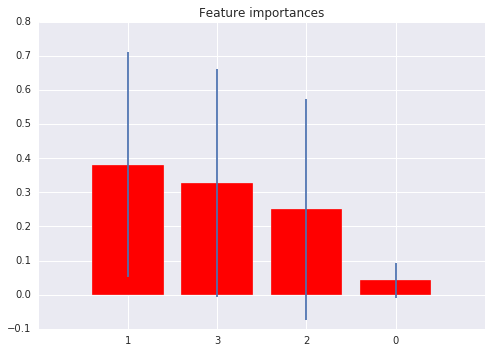

In [228]:
#graph feature importance for 
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in trees.estimators_],
             axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# KMEANS to Classification
## Kmeans labels to KNN Classifier
### Builds models with kmeans labels as targets

Suggested addition: 
- Build this section with test/train split and/or cross validation
- Output and Compare classification results from the "best" and "worse" labels
- Plot Knn results

In [229]:
knn = KNeighborsClassifier()
knn.fit(X, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [230]:
exp = labels
predicted = knn.predict(x)

In [231]:
print(metrics.classification_report(exp, predicted))
print(metrics.confusion_matrix(exp, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          1       0.89      1.00      0.94         8
          2       0.00      0.00      0.00         1

avg / total       0.94      0.97      0.96        33

[[24  0  0]
 [ 0  8  0]
 [ 0  1  0]]


# B SECTION
## Hierarchical Clustering - Conduct exploration and apply labels

#### 1. Create the linkage for clustering

Suggesions to add: 
- loop through distances and paramters to find the best cophrenetic source
- Explore the dendrograms to determine what criteria to use for clusters

In [232]:
Z = linkage(X, 'ward')

In [233]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.88957255706074634

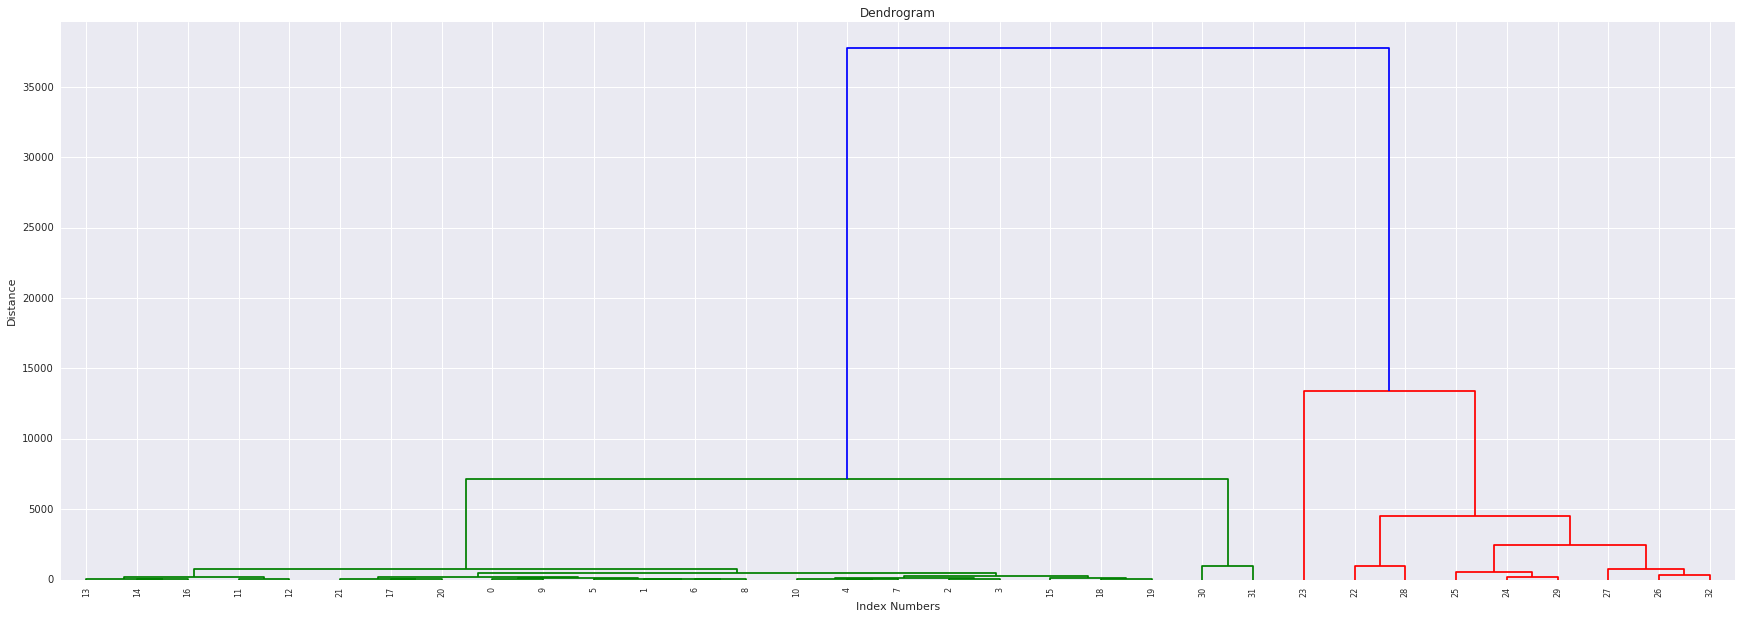

In [234]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

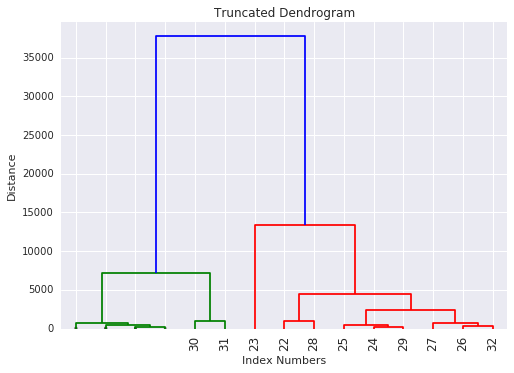

In [235]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [236]:
max_d = 30
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 6,  7, 11, 12,  9,  8,  7,  9,  7,  6, 10,  2,  3,  1,  1, 15,  1,
        4, 13, 14,  4,  5, 18, 26, 20, 22, 23, 25, 19, 21, 16, 17, 24], dtype=int32)

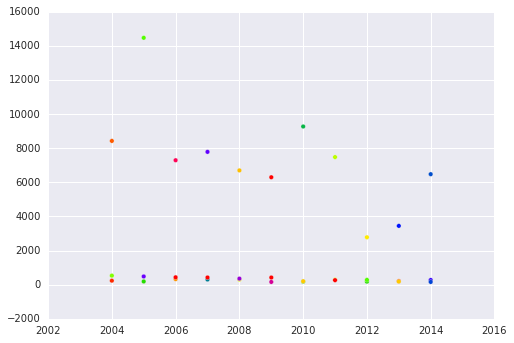

In [237]:
plt.scatter(X[:,0], X[:,2], c=clusters, cmap='prism')
plt.show()

# Hierarchical Clustering to Classification
## Hierarchical Clustering --> Extra Trees Classifier
Applying hierarchical clustering gueses to classification algorithms. What kind of insight do you get from adding classification models at the end of your workflow?

Suggested addition: 
- Build this section with test/train split and/or cross validation
- Output and Compare classification results from the "best" and "worse" labels

In [238]:
trees2 = ExtraTreesClassifier()
trees2.fit(X, clusters) #clusters from hierarchical fclusters above

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [239]:
print(X[:5])

print(trees2.feature_importances_)

[[2004  242  235   71]
 [2005  221  190   61]
 [2006  392  329   71]
 [2007  366  304  107]
 [2008  333  300   79]]
[ 0.16745273  0.25984633  0.32458624  0.2481147 ]


## Hierarchical Clustering --> KNN Classifier

In [240]:
knn2 = KNeighborsClassifier()
knn2.fit(X, clusters)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [241]:
exp2 = clusters
predicted2 = knn2.predict(X)

In [242]:
print(metrics.classification_report(exp, predicted))
print(metrics.confusion_matrix(exp, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          1       0.89      1.00      0.94         8
          2       0.00      0.00      0.00         1

avg / total       0.94      0.97      0.96        33

[[24  0  0]
 [ 0  8  0]
 [ 0  1  0]]


# SECTION C
## PCA to Logistic Regression

Suggestion to add: 
- Explore the PCA components & graph eigenvalues (scree plot) and cumulative explained variance
- Find the most influential records in various PCA components, as well as relationship to loadings
- Do you need to scale and transform the data before applying models? 
- Graph eigenvalues in components along with loadings
- Add objects to your pipeline and Gridsearch, such as train/test split or cross validation
- Plot the outputs of regression given different # components applied

In [243]:
PCA_ap = PCA(n_components=4)
Y = PCA_ap.fit_transform(X)

In [244]:
print PCA_ap.n_components
print PCA_set.explained_variance_
x_vals = np.arange(1, PCA_ap.n_components)

4
[  2.54801800e+07   5.27045912e+04   3.04361873e+03   8.62336747e+00]


In [245]:
x.columns

Index([u'Year', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions'],
      dtype='object')

In [246]:
pca_loadings = pd.DataFrame(PCA_ap.components_.T, columns=['Year', 'Dep Cancellations', 'Arrival Cancellations',
       'Dep Diversions'] )
print pca_loadings

       Year  Dep Cancellations  Arrival Cancellations  Dep Diversions
0 -0.000116          -0.004164               0.006314        0.999971
1  0.673041           0.444510               0.591120       -0.001804
2  0.736667          -0.331736              -0.589293        0.002425
3  0.065853          -0.832072               0.550700       -0.006934


In [247]:
ap_pca = pd.DataFrame(Y, columns=['PC1', 'PC2', 'PC3', 'PC4'])
ap_pca.sort_values(by='PC1', ascending=False)

,PC1,PC2,PC3,PC4
23,16471.506954,796.388016,39.211257,0.976857
28,8856.739269,-135.469109,-129.494680,2.279889
22,7997.352152,194.110532,46.257902,-3.557337
25,6812.879557,-222.268521,-108.892703,-1.448526
29,6424.136430,-213.755526,-80.365688,2.361859
24,6336.425242,-130.676452,73.737635,-3.275598
26,5367.520395,-343.323874,-6.382255,-1.767318
32,5289.680084,-37.113834,100.682528,4.822777
27,4736.221098,-503.122030,-23.429566,-1.398161
31,1001.049756,-465.652883,127.595064,1.371533


In [248]:
PCA_chain = PCA(n_components=4)
logistic = linear_model.LogisticRegression()
pipe = Pipeline(steps=[('pca', PCA_chain), ('logistic', logistic)])

In [249]:
PCA_chain.fit(X)

PCA(copy=True, n_components=4, whiten=False)

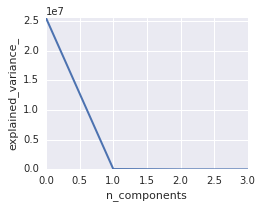

In [250]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(PCA_chain.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [ ]:
#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()